# Code for varying final time and amount of data points for neural ODE

In this code, we experiment with changing the simulation end points, as well as the amount of data points in the data set, to see where limits are of the neural ODE approach to inferring the GRN from data

In [1]:
import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


56


check


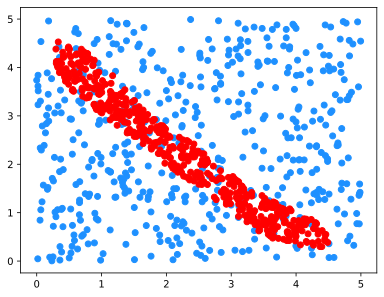

No change applied to TS or repr data


In [12]:
data_noise = 0.0
plotlim = [-0.2, 1.2]
subfolder = 'traj_TS'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('TS', noise = data_noise, plotlim = plotlim, random_state = seed, label = 'vector', deltat=1, batch_size=500)

In [13]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 10, 1
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = False
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'bottleneck' #outside

In [14]:
num_epochs = 100 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3)

from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
# verbose = True for more details
l,lv = trainer_anode.train(dataloader, num_epochs)

1

Iteration 0/7
Loss: 5.618
Epoch 1: 5.233

Iteration 0/7
Loss: 5.145
Epoch 2: 5.044

Iteration 0/7
Loss: 4.710
Epoch 3: 4.837

Iteration 0/7
Loss: 4.150
Epoch 4: 4.605

Iteration 0/7
Loss: 4.415
Epoch 5: 4.256

Iteration 0/7
Loss: 4.236
Epoch 6: 4.176

Iteration 0/7
Loss: 3.908
Epoch 7: 3.941

Iteration 0/7
Loss: 3.541
Epoch 8: 4.046

Iteration 0/7
Loss: 4.277
Epoch 9: 3.718

Iteration 0/7
Loss: 3.401
Epoch 10: 3.659

Iteration 0/7
Loss: 3.780
Epoch 11: 3.576

Iteration 0/7
Loss: 3.150
Epoch 12: 3.436

Iteration 0/7
Loss: 3.793
Epoch 13: 3.309

Iteration 0/7
Loss: 3.367
Epoch 14: 3.241

Iteration 0/7
Loss: 3.274
Epoch 15: 3.254

Iteration 0/7
Loss: 3.574
Epoch 16: 3.043

Iteration 0/7
Loss: 3.214
Epoch 17: 3.038

Iteration 0/7
Loss: 3.204
Epoch 18: 3.012

Iteration 0/7
Loss: 3.318
Epoch 19: 2.989

Iteration 0/7
Loss: 2.955
Epoch 20: 3.020

Iteration 0/7
Loss: 2.784
Epoch 21: 3.000

Iteration 0/7
Loss: 3.089
Epoch 22: 3.026

Iteration 0/7
Loss: 2.855
Epoch 23: 3.002

Iteration 0/7
Los

2.898513044629778
('flow.dynamics.fc1_time.0.weight', Parameter containing:
tensor([[ 0.7358,  0.2621],
        [-0.2246,  0.7661]], requires_grad=True))
('flow.dynamics.fc1_time.0.bias', Parameter containing:
tensor([0.1200, 0.4377], requires_grad=True))
('flow.dynamics.fc3_time.0.weight', Parameter containing:
tensor([[-0.4850, -0.2109],
        [ 0.4171,  0.1290]], requires_grad=True))
('flow.dynamics.fc3_time.0.bias', Parameter containing:
tensor([-0.5735,  0.4396], requires_grad=True))
('linear_layer.weight', Parameter containing:
tensor([[-0.2040, -0.1314],
        [-0.2413,  0.0328]], requires_grad=True))
('linear_layer.bias', Parameter containing:
tensor([0.3019, 0.1607], requires_grad=True))


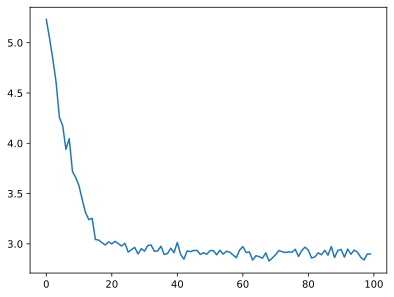

In [15]:
print(l)
for param in anode.named_parameters():
    print(param)

plt.plot(range(0,len(lv)),lv)